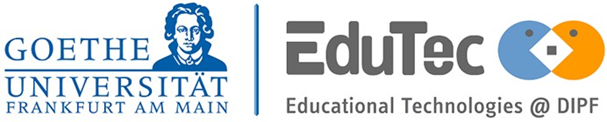

This work is part of a bachelor thesis entitled "Robuste transformatorbasierte Sprache-zu-Text-Methoden für die automatische Transkription von Interviews"


Presented by
Alhag Ali, Mahmoud
(7183665)


- First examiner:    	Prof. Dr. Hendrik Drachsler
- Second examiner: 	  Dr. Karsten Tolle
- Supervisor:        	Sebastian Gombert

# **Fine-tuning XLS-R for Multi-Lingual ASR with 🤗 Transformers**

***New (01/2024)***: *This blog post is based on (https://huggingface.co/blog/fine-tune-xlsr-wav2vec2) with the customization of the data import and the German language. For fine tuning the Wav2Vec2.0 XLS-R with German noisy audios.*

**Wav2Vec2** is a state-of-the-art model for Automatic Speech Recognition (ASR) that was introduced by Alexei Baevski, Michael Auli, and Alex Conneau in September 2020. The model leverages self-supervised learning to pretrain on large amounts of unlabeled speech data. After showing impressive results on LibriSpeech, one of the most widely used English datasets for ASR, Facebook AI extended the model to support multiple languages and named it XLSR. XLSR stands for cross-lingual speech representations and denotes the model’s capability of learning speech representations that generalize across languages.

Building on the success of **XLSR**, a large-scale self-supervised multilingual speech representation model, Arun Babu, Changhan Wang, Andros Tjandra, et al. introduced XLS-R in November 2021. XLS-R is inspired by the ''XLM-R for Speech’’ approach and uses nearly half a million hours of speech data from 128 languages to pretrain the model in a self-supervised manner. XLS-R offers a range of model sizes, from 300 million to two billion parameters, and achieves state-of-the-art results on various multilingual speech recognition tasks. The pretrained checkpoints are available on the 🤗 Hub:

- [**Wav2Vec2-XLS-R-300M**](https://huggingface.co/facebook/wav2vec2-xls-r-300m)
- [**Wav2Vec2-XLS-R-1B**](https://huggingface.co/facebook/wav2vec2-xls-r-1b)
- [**Wav2Vec2-XLS-R-2B**](https://huggingface.co/facebook/wav2vec2-xls-r-2b)

Similar to [BERT's masked language modeling objective](http://jalammar.github.io/illustrated-bert/), XLS-R learns contextualized speech representations by randomly masking feature vectors before passing them to a transformer network during self-supervised pre-training (*i.e.* diagram on the left below).

For fine-tuning, a single linear layer is added on top of the pre-trained network to train the model on labeled data of audio downstream tasks such as speech recognition, speech translation and audio classification (*i.e.* diagram on the right below).

![wav2vec2_structure](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/xls_r.png)

XLS-R shows impressive improvements over previous state-of-the-art results on both speech recognition, speech translation and speaker/language identification, *cf.* with Table 3-6, Table 7-10, and Table 11-12 respectively of the official [paper](https://ai.facebook.com/blog/xls-r-self-supervised-speech-processing-for-128-languages).

## Notebok Setup

This notebook provides a detailed explanation of how to fine-tune XLS-R, a large-scale self-supervised multilingual speech representation model, for automatic speech recognition (ASR). We focus on the pre-trained checkpoint Wav2Vec2-XLS-R-300M, which has been trained on 300 hours of speech data from 128 languages. To demonstrate the effectiveness of the model, we fine-tune it on the modified Common Voice ASR dataset, which is a low-resource dataset with only about 17 hours of validated training data.

Before we start, let's install `datasets` and `transformers`. Also, we need the `torchaudio` to load audio files and `jiwer` to evaluate our fine-tuned model using the [word error rate (WER)](https://huggingface.co/metrics/wer) metric ${}^1$.

In [ ]:
%%capture
!pip install datasets
!pip install datasets transformers==4.28.0
!pip install torchaudio
!pip install librosa
!pip install jiwer

 I want to upload my training checkpoints directly to the [🤗 Hub](https://huggingface.co/) while training. The [🤗 Hub](https://huggingface.co/) has integrated version control so I can be sure that no model checkpoint is getting lost during training.

To do so I have to store my authentication token from the Hugging Face website.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Then I need to install Git-LFS to upload my model checkpoints:

In [ ]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


## Prepare Data, Tokenizer, Feature Extractor

ASR models transcribe speech to text, which means that I both need a feature extractor that processes the speech signal to the model's input format, e.g. a feature vector, and a tokenizer that processes the model's output format to text.

In 🤗 Transformers, the XLS-R model is thus accompanied by both a tokenizer, called Wav2Vec2CTCTokenizer, and a feature extractor, called Wav2Vec2FeatureExtractor.

Let's start by creating the tokenizer to decode the predicted output classes to the output transcription.

## Create Wav2Vec2CTCTokenizer

A pre-trained XLS-R model maps the speech signal to a sequence of context representations as illustrated in the figure above. However, for speech recognition the model has to map this sequence of context representations to its corresponding transcription which means that a linear layer has to be added on top of the transformer block (shown in yellow in the diagram above). This linear layer is used to classifies each context representation to a token class analogous how, e.g., after pretraining a linear layer is added on top of BERT's embeddings for further classification - cf. with 'BERT' section of this blog post.

The output size of this layer corresponds to the number of tokens in the vocabulary, which does not depend on XLS-R's pretraining task, but only on the labeled dataset used for fine-tuning.

I load here the csv Dateien for Training and Test from my drive.

In [ ]:
# Using local Common Voice dataset

train_split = "/content/drive/MyDrive/data/Wav_Data/trainWav2.csv"
test_split = "/content/drive/MyDrive/data/Wav_Data/testWav2.csv"

train_splits = {"train": train_split}
test_splits = {"test": test_split}

In [ ]:
from datasets import load_dataset, load_metric, Audio
import datasets

SEP = ","

features = datasets.Features({
    "client_id": datasets.Value(dtype='string', id=None),
    "path": datasets.Value(dtype='string', id=None),
    "sentence": datasets.Value(dtype='string', id=None),
    "up_votes": datasets.Value(dtype='int64', id=None),
    "down_votes": datasets.Value(dtype='int64', id=None),
    "age": datasets.Value(dtype='string', id=None),
    "gender": datasets.Value(dtype='string', id=None),
    "accents": datasets.Value(dtype='string', id=None),
    "locale": datasets.Value(dtype='string', id=None),
    "segment": datasets.Value(dtype='string', id=None),
})


train = load_dataset("csv", sep=SEP, data_files=train_splits, features=features)
test = load_dataset("csv", sep=SEP, data_files=test_splits, features=features)


train = train.cast_column("path", datasets.Audio(sampling_rate=16000,decode=True, mono=True,  id=None))
test = test.cast_column("path", datasets.Audio(sampling_rate=16000,decode=True, mono=True,  id=None))

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating test split: 0 examples [00:00, ? examples/s]

Many ASR datasets only provide the target text, `'sentence'` for each audio array `'audio'` and file `'path'`. Common Voice actually provides much more information about each audio file, such as the `'accent'`, etc. Keeping the notebook as general as possible, we only consider the transcribed text for fine-tuning.

In [ ]:
train = train.remove_columns(["accents", "age", "client_id", "down_votes", "gender", "locale", "segment", "up_votes"])
test = test.remove_columns(["accents", "age", "client_id", "down_votes", "gender", "locale", "segment", "up_votes"])

In [ ]:
train

DatasetDict({
    train: Dataset({
        features: ['path', 'sentence'],
        num_rows: 7500
    })
})

In [ ]:
test

DatasetDict({
    test: Dataset({
        features: ['path', 'sentence'],
        num_rows: 2500
    })
})

In [ ]:
train["train"][0]["path"]["array"]

array([ 4.05009359e-13,  3.55271368e-14, -8.17124146e-14, ...,
        1.29453815e-03,  1.03532826e-03,  1.27123808e-03])

Let's write a short function to display some random samples of the dataset and run it a couple of times to get a feeling for the transcriptions.

In [ ]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(train["train"].remove_columns("path"), num_examples=10)

,sentence
0,Der Verbleib seiner Witwe ist ungeklärt.
1,In den ersten drei Spielzeiten war Harald Schaub beim Oberligisten Motor Zwickau nur Ergänzungsspieler.
2,In seiner Freizeit besuchte er Lehrgänge in Rechtswissenschaft.
3,Er gilt als der schwierigste Wanderweg in den Saybuscher Beskiden.
4,Bisher kam er auf neun Einsätze.
5,Der Reichskommissar stellte daraufhin nur die zum Protestantismus konvertierten Juden von Deportationen zurück.
6,Antragsberechtigt waren deutsche Staatsangehörige.
7,Johann Sebastian Bach nahm sie als Vorlage für zwei seiner Kantaten.
8,Zudem war er Mitglied der ähnlich gelagerten Pommerschen Gesellschaft.
9,Das Untier ernährt sich von Menschenfleisch und terrorisiert die heimische Bevölkerung schon längere Zeit.


I can see that the transcriptions contain some special characters, such as `,.?!;:`. Without a language model, it is much harder to classify speech chunks to such special characters because they don't really correspond to a characteristic sound unit. *E.g.*, the letter `"s"` has a more or less clear sound, whereas the special character `"."` does not.
Also in order to understand the meaning of a speech signal, it is usually not necessary to include special characters in the transcription.

Let's simply remove all characters that don't contribute to the meaning of a word and cannot really be represented by an acoustic sound and normalize the text.

In [ ]:
import re
chars_to_remove_regex = '[\,\?\.\!\-\;\:\"\“\%\‘\”\�\')(–’‚„]'

def remove_special_characters(batch):
    batch["sentence"] = re.sub(chars_to_remove_regex, '', batch["sentence"]).lower()
    return batch

In [ ]:
train = train["train"].map(remove_special_characters)
test = test["test"].map(remove_special_characters)

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Let's look at the processed text labels again.

In [ ]:
show_random_elements(train.remove_columns("path"), num_examples=10)

,sentence
0,die meisten dieser leihen hatten nur eine laufzeit von zwei bis drei monaten
1,nebenbei schreibt und produziert sie auch ihre eigene musik
2,daneben unterrichtete er als honorardozent kulturgeschichte an der technischen hochschule wien
3,stefan effenberg war jeweils zwei mal für die vereine aktiv
4,der verbleib dieser gegenstände ist unklar
5,während der semesterferien praktizierte er beim bauunternehmen josef riehl
6,das album war international erfolgreich und konnte sich in den charts platzieren
7,van der leyen habe aus terminlichen gründen abgesagt
8,lohnt sich eine solaranlage bei der aktuellen einspeisevergütung
9,die dadurch verursachten vibrationen stellen eine ernsthafte bedrohung für die umliegenden befunde dar


Good! This looks better. I have removed most special characters from transcriptions and normalized them to lower-case only.


I want here to change the Umlauten und the Szett to tow letters.

In [ ]:
def replace_hatted_characters(batch):
    batch["sentence"] = re.sub('[ä]', 'ae', batch["sentence"])
    batch["sentence"] = re.sub('[ö]', 'oe', batch["sentence"])
    batch["sentence"] = re.sub('[ü]', 'ue', batch["sentence"])
    batch["sentence"] = re.sub('[ß]', 'ss', batch["sentence"])
    return batch

In [ ]:
common_voice_train = train.map(replace_hatted_characters)
common_voice_test = test.map(replace_hatted_characters)

In CTC, it is common to classify speech chunks into letters, so we will do the same here.
Let's extract all distinct letters of the training and test data and build our vocabulary from this set of letters.

I write a mapping function that concatenates all transcriptions into one long transcription and then transforms the string into a set of chars.
It is important to pass the argument `batched=True` to the `map(...)` function so that the mapping function has access to all transcriptions at once.

In [ ]:
def extract_all_chars(batch):
  all_text = " ".join(batch["sentence"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

In [ ]:
vocab_train = train.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_train.column_names)
vocab_test = test.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_test.column_names)

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Now, I create the union of all distinct letters in the training dataset and test dataset and convert the resulting list into an enumerated dictionary.

In [ ]:
vocab_list = list(set(vocab_train["vocab"][0]) | set(vocab_test["vocab"][0]))

In [ ]:
vocab_dict = {v: k for k, v in enumerate(sorted(vocab_list))}
vocab_dict

{' ': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 'ß': 27,
 'ä': 28,
 'ö': 29,
 'ü': 30}

To make it clearer that `" "` has its own token class, I give it a more visible character `|`. In addition, I also add an "unknown" token so that the model can later deal with characters not encountered in Common Voice's training set.

In [ ]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

Finally, we also add a padding token that corresponds to CTC's "*blank token*". The "blank token" is a core component of the CTC algorithm. For more information, please take a look at the "Alignment" section [here](https://distill.pub/2017/ctc/).

In [ ]:
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

33

Let's now save the vocabulary as a json file.

In [ ]:
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In a final step, we use the json file to load the vocabulary into an instance of the `Wav2Vec2CTCTokenizer` class.

In [ ]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

If one wants to re-use the just created tokenizer with the fine-tuned model of this notebook, it is strongly advised to upload the `tokenizer` to the [🤗 Hub](https://huggingface.co/). Let's call the repo to which I will upload the files
`"wav2vec2-xls-r-300m-poor-data-german-colab12"`:

In [ ]:
repo_name = "wav2vec2-xls-r-300m-poor-data-german-colab12"

and upload the tokenizer to the 🤗 Hub.

In [ ]:
tokenizer.push_to_hub(repo_name)

CommitInfo(commit_url='https://huggingface.co/AlhagAli/wav2vec2-xls-r-300m-poor-data-german-colab12/commit/a75141bacc1763d486e1ebc2c8f12512965618ef', commit_message='Upload tokenizer', commit_description='', oid='a75141bacc1763d486e1ebc2c8f12512965618ef', pr_url=None, pr_revision=None, pr_num=None)

### Create `Wav2Vec2FeatureExtractor`

Speech is a continuous signal and to be treated by computers, it first has to be discretized, which is usually called sampling. The sampling rate hereby plays an important role in that it defines how many data points of the speech signal are measured per second. Therefore, sampling with a higher sampling rate results in a better approximation of the real speech signal but also necessitates more values per second.

A pretrained checkpoint expects its input data to have been sampled more or less from the same distribution as the data it was trained on. The same speech signals sampled at two different rates have a very different distribution, e.g., doubling the sampling rate results in data points being twice as long. Thus, before fine-tuning a pretrained checkpoint of an ASR model, it is crucial to verify that the sampling rate of the data that was used to pretrain the model matches the sampling rate of the dataset used to fine-tune the model.

XLS-R was pretrained on audio data of Babel, Multilingual LibriSpeech (MLS), Common Voice, VoxPopuli, and VoxLingua107 at a sampling rate of 16kHz. Common Voice, in its original form, has a sampling rate of 48kHz, thus we will have to downsample the fine-tuning data to 16kHz in the following.

A `Wav2Vec2FeatureExtractor` object requires the following parameters to be instantiated:

- `feature_size`: Speech models take a sequence of feature vectors as an input. While the length of this sequence obviously varies, the feature size should not. In the case of Wav2Vec2, the feature size is 1 because the model was trained on the raw speech signal ${}^2$.
- `sampling_rate`: The sampling rate at which the model is trained on.
- `padding_value`: For batched inference, shorter inputs need to be padded with a specific value
- `do_normalize`: Whether the input should be *zero-mean-unit-variance* normalized or not. Usually, speech models perform better when normalizing the input
- `return_attention_mask`: Whether the model should make use of an `attention_mask` for batched inference. In general, XLS-R models checkpoints should **always** use the `attention_mask`.

In [ ]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)

Great, XLS-R's feature extraction pipeline is thereby fully defined!

For improved user-friendliness, the feature extractor and tokenizer are *wrapped* into a single `Wav2Vec2Processor` class so that one only needs a `model` and `processor` object.

In [ ]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

Next, I can prepare the dataset.

## Preprocess Data
So far, I have not looked at the actual values of the speech signal but just the transcription. In addition to sentence, our datasets include two more column names path and sentence. path states the absolute path of the audio file. Let's take a look.

XLS-R expects the input in the format of a 1-dimensional array of 16 kHz. This means that the audio file has to be loaded and resampled.

 Thankfully, `datasets` does this automatically by calling the other column `path`. Let try it out.

In [ ]:
common_voice_train[0]["sentence"]

'die distale haelfte der saegescheide ist ebenfalls verdunkelt'

In [ ]:
common_voice_train[0]["path"]

{'path': '//content//drive//MyDrive//data//Wav_Data//train/common_voice_de_31945275.wav',
 'array': array([ 4.05009359e-13,  3.55271368e-14, -8.17124146e-14, ...,
         1.29453815e-03,  1.03532826e-03,  1.27123808e-03]),
 'sampling_rate': 16000}

This seemed to have worked! Let's listen to a couple of audio files to better understand the dataset and verify that the audio was correctly loaded.

**Note**: *You can click the following cell a couple of times to listen to different speech samples.*

In [ ]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(common_voice_train)-1)

print(common_voice_train[rand_int]["sentence"])
ipd.Audio(data=common_voice_train[rand_int]["path"]["array"], autoplay=True, rate=16000)

sie spielte auch klavier


It can be heard, that the speakers change along with their speaking rate, accent, and background environment, etc. Overall, the recordings sound acceptably clear though, which is to be expected from a crowd-sourced read speech corpus.

Let's do a final check that the data is correctly prepared, by printing the shape of the speech input, its transcription, and the corresponding sampling rate.

In [ ]:
rand_int = random.randint(0, len(common_voice_train)-1)

print("Target text:", common_voice_train[rand_int]["sentence"])
print("Input array shape:", common_voice_train[rand_int]["path"]["array"].shape)
print("Sampling rate:", common_voice_train[rand_int]["path"]["sampling_rate"])

Target text: von ihm aus kann der zusammenfluss von isar und loisach gesehen werden
Input array shape: (92736,)
Sampling rate: 16000


Finally, I can leverage `Wav2Vec2Processor` to process the data to the format expected by `Wav2Vec2ForCTC` for training. To do so let's make use of Dataset's [`map(...)`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=map#datasets.DatasetDict.map) function.

First, I load and resample the audio data, simply by calling `batch["audio"]`.
Second, we extract the `input_values` from the loaded audio file. In our case, the `Wav2Vec2Processor` only normalizes the data. For other speech models, however, this step can include more complex feature extraction, such as [Log-Mel feature extraction](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).
Third, we encode the transcriptions to label ids.

**Note**: This mapping function is a good example of how the `Wav2Vec2Processor` class should be used. In "normal" context, calling `processor(...)` is redirected to `Wav2Vec2FeatureExtractor`'s call method. When wrapping the processor into the `as_target_processor` context, however, the same method is redirected to `Wav2Vec2CTCTokenizer`'s call method.
For more information please check the [docs](https://huggingface.co/transformers/master/model_doc/wav2vec2.html#transformers.Wav2Vec2Processor.__call__).

In [ ]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

def prepare_dataset(batch):
    audio = batch["path"]

    # batched output is "un-batched"
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])

    with processor.as_target_processor():
        batch["labels"] = processor(batch["sentence"]).input_ids
    return batch

In [ ]:
common_voice_train = common_voice_train.map(prepare_dataset, remove_columns=common_voice_train.column_names, num_proc=4) #
common_voice_test = common_voice_test.map(prepare_dataset, remove_columns=common_voice_test.column_names, num_proc=4) #, num_proc=4

Map (num_proc=4):   0%|          | 0/7500 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call

Map (num_proc=4):   0%|          | 0/2500 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call

Long input sequences require a lot of memory. XLS-R is based on `self-attention` the memory requirement scales quadratically with the input length for long input sequences (*cf.* with [this](https://www.reddit.com/r/MachineLearning/comments/genjvb/d_why_is_the_maximum_input_sequence_length_of/) reddit post). In case this demo crashes with an "Out-of-memory" error for you, you might want to uncomment the following lines to filter all sequences that are longer than 5 seconds for training.

In [ ]:
max_input_length_in_sec = 5.0
common_voice_train = common_voice_train.filter(lambda x: x < max_input_length_in_sec * processor.feature_extractor.sampling_rate, input_columns=["input_length"])

Filter:   0%|          | 0/7500 [00:00<?, ? examples/s]

Awesome, now we are ready to start training!

## Training

The data is processed so that we are ready to start setting up the training pipeline. We will make use of 🤗's [Trainer](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer) for which we essentially need to do the following:

- Define a data collator. In contrast to most NLP models, XLS-R has a much larger input length than output length. *E.g.*, a sample of input length 50000 has an output length of no more than 100. Given the large input sizes, it is much more efficient to pad the training batches dynamically meaning that all training samples should only be padded to the longest sample in their batch and not the overall longest sample. Therefore, fine-tuning XLS-R requires a special padding data collator, which we will define below

- Evaluation metric. During training, the model should be evaluated on the word error rate. We should define a `compute_metrics` function accordingly

- Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.

- Define the training configuration.

After having fine-tuned the model, we will correctly evaluate it on the test data and verify that it has indeed learned to correctly transcribe speech.

### Set-up Trainer

Let's start by defining the data collator. The code for the data collator was copied from [this example](https://github.com/huggingface/transformers/blob/7e61d56a45c19284cfda0cee8995fb552f6b1f4e/examples/pytorch/speech-recognition/run_speech_recognition_ctc.py#L219).

Without going into too many details, in contrast to the common data collators, this data collator treats the `input_values` and `labels` differently and thus applies to separate padding functions on them (again making use of XLS-R processor's context manager). This is necessary because in speech input and output are of different modalities meaning that they should not be treated by the same padding function.
Analogous to the common data collators, the padding tokens in the labels with `-100` so that those tokens are **not** taken into account when computing the loss.

In [ ]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

Next, the evaluation metric is defined. As mentioned earlier, the predominant metric in ASR is the word error rate (WER), hence we will use it in this notebook as well.

In [ ]:
wer_metric = load_metric("wer")

<ipython-input-54-605de035dfd7>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")


In [ ]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

Now, I can load the pretrained checkpoint of [Wav2Vec2-XLS-R-300M](https://huggingface.co/facebook/wav2vec2-xls-r-300m). The tokenizer's `pad_token_id` must be to define the model's `pad_token_id` or in the case of `Wav2Vec2ForCTC` also CTC's.

Because the dataset is quite small and because Common Voice is quite noisy, fine-tuning Facebook's [wav2vec2-xls-r-300m checkpoint](https://huggingface.co/facebook/wav2vec2-xls-r-300m) seems to require some hyper-parameter tuning. Therefore, I had to play around a bit with different values for dropout, [SpecAugment](https://arxiv.org/abs/1904.08779)'s masking dropout rate, layer dropout, and the learning rate until training seemed to be stable enough.

**Note**: When using this notebook to train XLS-R on another language of Common Voice those hyper-parameter settings might not work very well. Feel free to adapt those depending on your use case.

In [ ]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-xls-r-300m",
    attention_dropout=0.1,
    hidden_dropout=0.1,
    feat_proj_dropout=0.0,
    mask_time_prob=0.05,
    layerdrop=0.1,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
)

config.json:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Some weights of the model checkpoint at facebook/wav2vec2-xls-r-300m were not used when initializing Wav2Vec2ForCTC: ['project_hid.weight', 'quantizer.weight_proj.bias', 'project_q.weight', 'quantizer.weight_proj.weight', 'quantizer.codevectors', 'project_q.bias', 'project_hid.bias']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification m

The first component of XLS-R consists of a stack of CNN layers that are used to extract acoustically meaningful - but contextually independent - features from the raw speech signal. This part of the model has already been sufficiently trained during pretraining and as stated in the [paper](https://arxiv.org/pdf/2006.13979.pdf) does not need to be fine-tuned anymore.
Thus, we can set the `requires_grad` to `False` for all parameters of the *feature extraction* part.

In [ ]:
model.freeze_feature_extractor()

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1643: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5.Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


In a final step, I define all parameters related to training.
To give more explanation on some of the parameters:
- `group_by_length` makes training more efficient by grouping training samples of similar input length into one batch. This can significantly speed up training time by heavily reducing the overall number of useless padding tokens that are passed through the model
- `learning_rate` and `weight_decay` were heuristically tuned until fine-tuning has become stable. Note that those parameters strongly depend on the Common Voice dataset and might be suboptimal for other speech datasets.

For more explanations on other parameters, one can take a look at the [docs](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer#trainingarguments).

During training, a checkpoint will be uploaded asynchronously to the hub every Epoch. It allows you to also play around with the demo widget even while your model is still training.

**Note**: If one does not want to upload the model checkpoints to the hub, simply set `push_to_hub=False`.

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir=repo_name,
  overwrite_output_dir= True,
  group_by_length=True,
  per_device_train_batch_size=10,
  gradient_accumulation_steps=2,
  evaluation_strategy="epoch",
  num_train_epochs=7,
  fp16=True,
  gradient_checkpointing=True,
  save_strategy="epoch",
  logging_steps=132,
  learning_rate=3e-4,
  warmup_steps=500,
  save_total_limit=2,
  load_best_model_at_end=True,
  push_to_hub=True,
)

Now, all instances can be passed to Trainer and we are ready to start training!

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=common_voice_train,
    eval_dataset=common_voice_test,
    tokenizer=processor.feature_extractor,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:127: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/AlhagAli/wav2vec2-xls-r-300m-poor-data-german-colab12 into local empty directory.


The Training took over 1 hour.

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommend

Epoch,Training Loss,Validation Loss,Wer
1,7.348400,3.127228,1.000000
2,2.972700,2.967914,1.000000
3,2.920200,3.275712,1.000000
4,2.898000,2.930574,0.999956
5,2.861200,2.867256,0.998291
6,2.581100,2.147925,0.999912
7,1.786900,1.642093,0.963013


/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Tran

TrainOutput(global_step=924, training_loss=3.33836470434676, metrics={'train_runtime': 4195.4186, 'train_samples_per_second': 4.396, 'train_steps_per_second': 0.22, 'total_flos': 2.3425390105439616e+18, 'train_loss': 3.33836470434676, 'epoch': 7.0})

I can use the trainer.evaluate() function to evaluate.

In [ ]:
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


{'eval_loss': 1.6420925855636597,
 'eval_wer': 0.9630132784083439,
 'eval_runtime': 246.2353,
 'eval_samples_per_second': 10.153,
 'eval_steps_per_second': 1.271,
 'epoch': 7.0}

I can now upload the result of the training to the 🤗 Hub, just execute this instruction:

In [ ]:
trainer.push_to_hub()

To https://huggingface.co/AlhagAli/wav2vec2-xls-r-300m-poor-data-german-colab12
   f0e477d..0a040f5  main -> main

   f0e477d..0a040f5  main -> main

To https://huggingface.co/AlhagAli/wav2vec2-xls-r-300m-poor-data-german-colab12
   0a040f5..9733992  main -> main

   0a040f5..9733992  main -> main



'https://huggingface.co/AlhagAli/wav2vec2-xls-r-300m-poor-data-german-colab12/commit/0a040f5d3b578d12c731e2683240e9122cad4368'

I can now share this model with all my friends, family, favorite pets: they can all load it with the identifier "my-username/the-name-you-picked" so for instance:

In [ ]:
from transformers import AutoModelForCTC, Wav2Vec2Processor

model = AutoModelForCTC.from_pretrained("AlhagAli/wav2vec2-xls-r-300m-poor-data-german-colab12")
processor = Wav2Vec2Processor.from_pretrained("AlhagAli/wav2vec2-xls-r-300m-poor-data-german-colab12")

config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/331 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Evaluate

In [ ]:
from transformers import AutoModelForCTC, Wav2Vec2Processor

model = Wav2Vec2ForCTC.from_pretrained(repo_name).to("cuda")
processor = Wav2Vec2Processor.from_pretrained(repo_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
input_dict = processor(common_voice_test[0]["input_values"],
                       return_tensors="pt", padding=True)

logits = model(input_dict.input_values.to("cuda")).logits

pred_ids = torch.argmax(logits, dim=-1)[0]

It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


In [ ]:
common_voice_test_transcription = test

In [ ]:
print("Prediction:")
print(processor.decode(pred_ids))

print("\nReference:")
print(common_voice_test_transcription[1000]["sentence"].lower())

Prediction:
aust zer zeit ist eine lerlin bei u bekat

Reference:
aus dieser zeit ist ein lehrling bei ihm bekannt
